In [1]:
import os, sys, warnings
import numpy as np, sequentia as seq, matplotlib.pyplot as plt
import sequentia.preprocessing
from sequentia.classifiers import HMM, HMMClassifier, DTWKNN
from tqdm.auto import tqdm

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from lstm import LSTMClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

In [2]:
gestures_map = {
    'nd': 'nod',
    'mnd': 'multiple nods',
    'fu': 'face-up',
    'fd': 'face-down',
    'sh': 'shake',
    't': 'turn',
    'ti': 'tilt'
}

gestures = list(gestures_map.keys())

In [3]:
fields = ['Rx', 'Ry', 'Rz']

In [4]:
# Containers to store classifiers and results
clfs, results = {}, {'hmm': {}, 'knn': {}, 'lstm': {}}

In [5]:
# Load the MoCap dataset
loader = MoCapLoader(normalized=False)
X, y = loader.load(fields)

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [6]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, random_state=rng, stratify=True)

Training set size: 841
Validation set size: 258
Test set size: 196


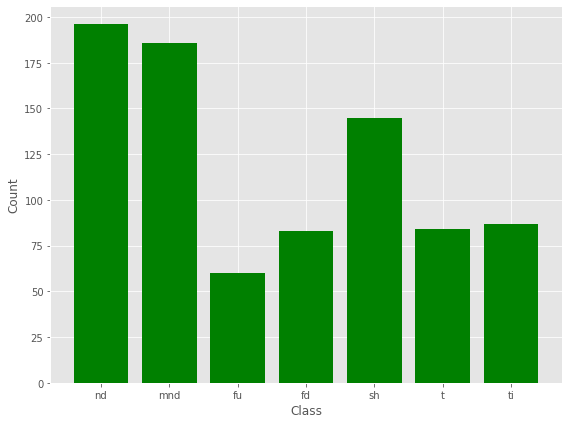

In [7]:
# MoCap dataset class counts (training set)
show_class_counts(y_train, gestures, title=None)

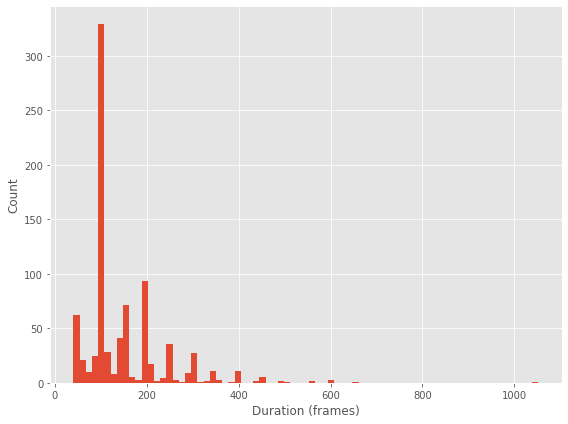

In [8]:
# Histogram of MoCap dataset gesture durations (training set)
show_durations(X_train, bins=75, title=None)

## Preprocessing

In [9]:
# Create a preprocessing pipeline
def pre(XX):
    XX = seq.preprocessing.filtrate(XX, n=10, method='median')
    XX = smart_downsample(XX, m=50, method='decimate')
    XX = seq.preprocessing.center(XX)
    return XX

In [10]:
# Function for visualizing gesture signals
def plot_gesture(gesture, label, figsize=(7, 6), same_scale=True, title=None):
    title = "Head rotation vectors for a '{}' gesture".format(gestures_map[label]) if title is None else title
    labels = ['$R_x$ (Roll)', '$R_y$ (Yaw)', '$R_z$ (Pitch)']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.plot(gesture[:, i], label=labels[i], color=colors[i])
        ax.legend(loc='lower right')
        if same_scale:
            pad = 0.1
            ax.set_ylim(gesture.min()-pad, gesture.max()+pad)
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    fig.suptitle(title)
    plt.show()

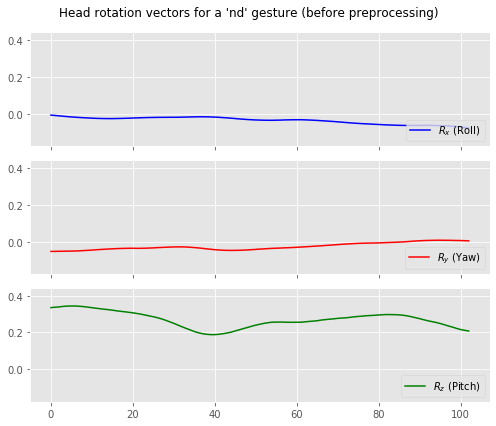

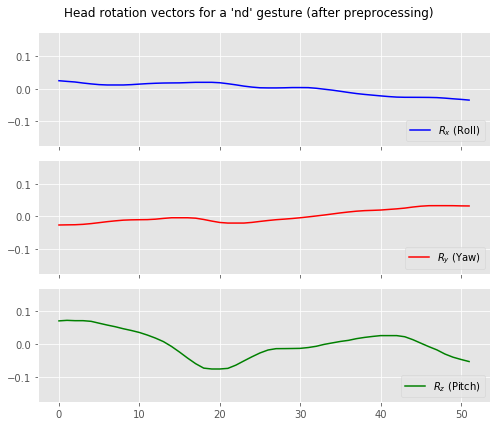

In [11]:
# Pick an example signal for visualization
x_sample, y_sample = X_train[0], y_train[0]
plot_gesture(x_sample, y_sample, title="Head rotation vectors for a '{}' gesture (before preprocessing)".format(y_sample))
plot_gesture(pre(x_sample), y_sample, title="Head rotation vectors for a '{}' gesture (after preprocessing)".format(y_sample))

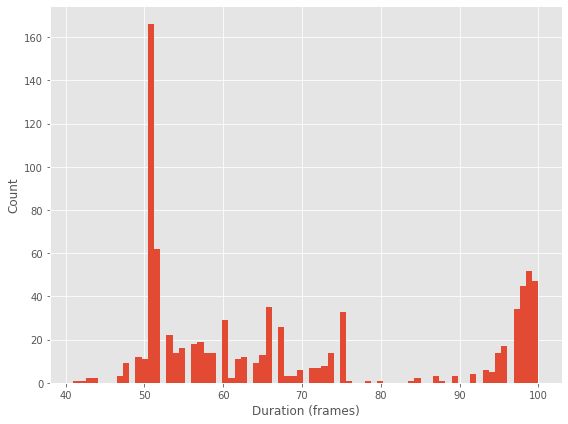

In [12]:
# Transform training data and plot histogram of MoCap dataset gesture durations (training set)
Xp_train = pre(X_train)
show_durations(Xp_train, bins=75, title=None)

In [13]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre(X_val), pre(X_test)

## DTWKNN classifier

### Fitting the model

In [14]:
%%time
# Create and fit a DTWKNN classifier using the single nearest neighbor and a radius of 1
# NOTE: The radius parameter is a parameter that constrains the FastDTW algorithm.
clfs['knn'] = DTWKNN(k=1, radius=1)
clfs['knn'].fit(Xp_train, y_train)

CPU times: user 4.54 ms, sys: 3.4 ms, total: 7.95 ms
Wall time: 5.66 ms


### Evaluating the model

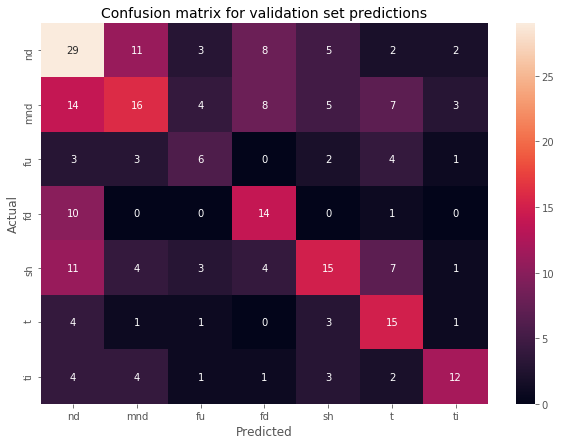

Accuracy: 41.47%
CPU times: user 651 ms, sys: 346 ms, total: 997 ms
Wall time: 32min 53s


In [15]:
%%time
results['knn']['validation'] = clfs['knn'].evaluate(Xp_val, y_val, labels=gestures, n_jobs=-1)
show_results(*results['knn']['validation'], dataset='validation', labels=gestures)

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

### Training the model

In [16]:
%%time

# Create HMMs to represent each class
#
# NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
# According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
# - Too many states in the HMMs
# - Too many dimensions in the input data, which leads to a large covariance matrix
# - Too few training examples
hmms = []
for g in tqdm(gestures, desc='Training HMMs'):
    hmm = HMM(label=g, n_states=7, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([Xp_train[i] for i, label in enumerate(y_train) if label == g])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clfs['hmm'] = HMMClassifier()
clfs['hmm'].fit(hmms)


CPU times: user 37.3 s, sys: 212 ms, total: 37.5 s
Wall time: 38.2 s


### Evaluating the model

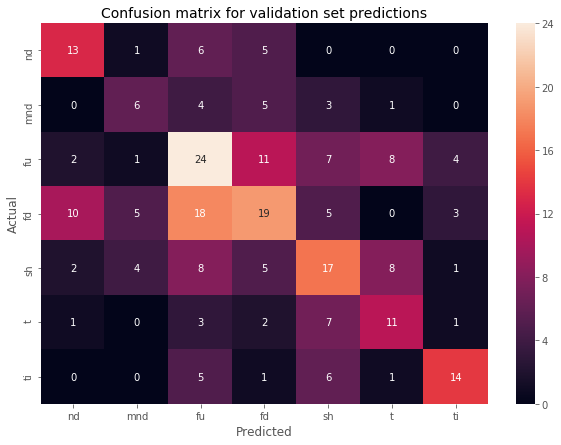

Accuracy: 40.31%
CPU times: user 818 ms, sys: 35.7 ms, total: 854 ms
Wall time: 886 ms


In [17]:
%%time
results['hmm']['validation'] = clfs['hmm'].evaluate(Xp_val, y_val)
show_results(*results['hmm']['validation'], dataset='validation', labels=gestures)

In [18]:
with np.printoptions(precision=3, suppress=True):
    display(hmms[0].initial)
    display(hmms[0].transitions)

array([0.241, 0.185, 0.14 , 0.066, 0.181, 0.025, 0.162])

array([[0.967, 0.022, 0.   , 0.   , 0.01 , 0.001, 0.   ],
       [0.   , 0.981, 0.006, 0.001, 0.01 , 0.001, 0.001],
       [0.   , 0.   , 0.969, 0.01 , 0.016, 0.004, 0.   ],
       [0.   , 0.   , 0.   , 0.986, 0.008, 0.005, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.962, 0.027, 0.012],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.997, 0.003],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

## LSTM classifier

### Fitting the model

In [22]:
%%time
from tensorflow.keras.optimizers import Adam
clfs['lstm'] = LSTMClassifier(epochs=150, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
hist = clfs['lstm'].fit(Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True)

Train on 841 samples, validate on 258 samples
Epoch 1/150
841/841 [==============================] - 7s 8ms/sample - loss: 1.9321 - accuracy: 0.2152 - val_loss: 1.8978 - val_accuracy: 0.2326
Epoch 2/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.8858 - accuracy: 0.2485 - val_loss: 1.8715 - val_accuracy: 0.2209
Epoch 3/150
841/841 [==============================] - 1s 1ms/sample - loss: 1.8708 - accuracy: 0.2069 - val_loss: 1.8577 - val_accuracy: 0.2403
Epoch 4/150
841/841 [==============================] - 1s 1ms/sample - loss: 1.8626 - accuracy: 0.2283 - val_loss: 1.8564 - val_accuracy: 0.2171
Epoch 5/150
841/841 [==============================] - 1s 1ms/sample - loss: 1.8650 - accuracy: 0.2283 - val_loss: 1.8598 - val_accuracy: 0.2287
Epoch 6/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.8596 - accuracy: 0.2319 - val_loss: 1.8547 - val_accuracy: 0.2287
Epoch 7/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.8591 

Epoch 57/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.7681 - accuracy: 0.2759 - val_loss: 1.8521 - val_accuracy: 0.2791
Epoch 58/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.7594 - accuracy: 0.2925 - val_loss: 1.8258 - val_accuracy: 0.2752
Epoch 59/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.7371 - accuracy: 0.3056 - val_loss: 1.8348 - val_accuracy: 0.3217
Epoch 60/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.7480 - accuracy: 0.2901 - val_loss: 1.7990 - val_accuracy: 0.2674
Epoch 61/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.7424 - accuracy: 0.2771 - val_loss: 1.7915 - val_accuracy: 0.2752
Epoch 62/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.7519 - accuracy: 0.2961 - val_loss: 1.7901 - val_accuracy: 0.2984
Epoch 63/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.7277 - accuracy: 0.2711 - val_loss: 1.8323 -

841/841 [==============================] - 2s 3ms/sample - loss: 1.5609 - accuracy: 0.3805 - val_loss: 1.6900 - val_accuracy: 0.3837
Epoch 114/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.5243 - accuracy: 0.3995 - val_loss: 1.6846 - val_accuracy: 0.3527
Epoch 115/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.5141 - accuracy: 0.4245 - val_loss: 1.6684 - val_accuracy: 0.3527
Epoch 116/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.5173 - accuracy: 0.3983 - val_loss: 1.6764 - val_accuracy: 0.3760
Epoch 117/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.4925 - accuracy: 0.4221 - val_loss: 1.6594 - val_accuracy: 0.3605
Epoch 118/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.4901 - accuracy: 0.4090 - val_loss: 1.6397 - val_accuracy: 0.3643
Epoch 119/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.4800 - accuracy: 0.4126 - val_loss: 1.7014 - val_ac

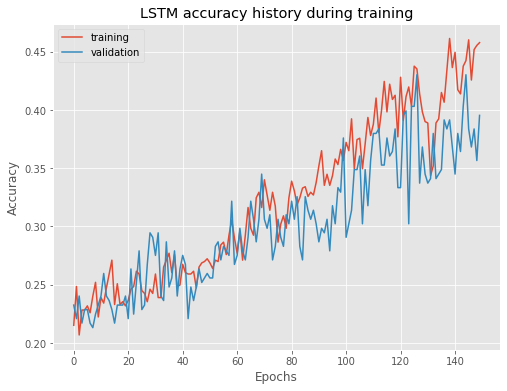

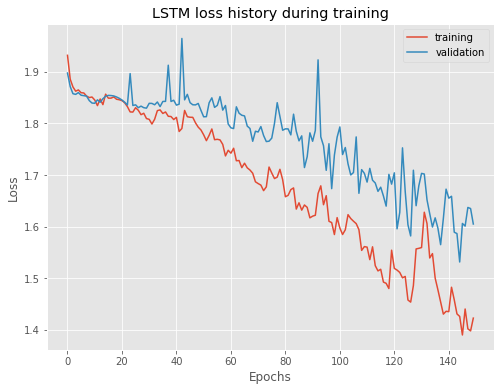

In [23]:
# Display accuracy and loss history during training
show_accuracy_history(hist)
show_loss_history(hist)

### Evaluating the model

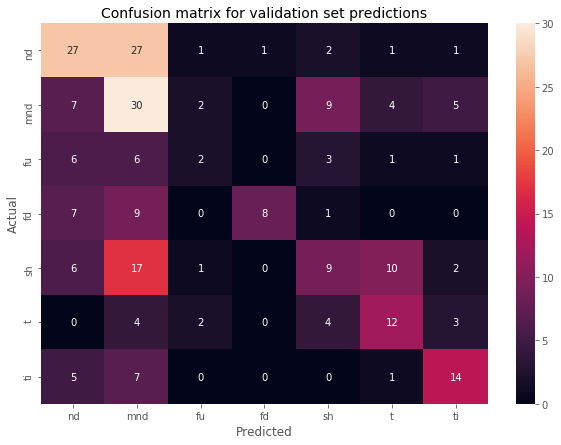

Accuracy: 39.53%
CPU times: user 928 ms, sys: 108 ms, total: 1.04 s
Wall time: 852 ms


In [24]:
%%time
results['lstm']['validation'] = clfs['lstm'].evaluate(Xp_val, y_val)
show_results(*results['lstm']['validation'], dataset='validation', labels=gestures)